In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math

In [2]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'

In [3]:
PEAKS_MIN_DIST_SCAN = 10.0
VALLEYS_MIN_DIST_SCAN = 10.0
PEAKS_THRESHOLD_SCAN = 0.5
VALLEYS_THRESHOLD_SCAN = 0.2

In [4]:
cuboids_df = pd.read_pickle('{}/precursor-cuboids-3did/exp-{}-run-{}-mz-100-1700-precursor-cuboids.pkl'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME))
cuboids_df.sort_values(by=['anchor_point_intensity'], ascending=False, inplace=True)


In [5]:
len(cuboids_df)

82132

In [6]:
cuboid_s = cuboids_df.iloc[36354]
cuboid_s

mz_lower                             1053.546388
mz_upper                             1056.047252
scan_lower                            132.000000
scan_upper                            176.000000
rt_lower                             2009.810603
rt_upper                             2016.688869
anchor_point_intensity                313.000000
anchor_point_mz                      1054.014756
anchor_point_scan                     147.000000
anchor_point_retention_time_secs     2015.101250
anchor_point_frame_id               18057.000000
number_of_isotope_clusters              3.000000
number_of_isotopes                      6.000000
precursor_cuboid_id                 68286.000000
Name: 68286, dtype: float64

In [7]:
mz_lower = cuboid_s.mz_lower
mz_upper = cuboid_s.mz_upper
scan_lower = cuboid_s.scan_lower
scan_upper = cuboid_s.scan_upper
rt_lower = cuboid_s.rt_lower
rt_upper = cuboid_s.rt_upper

In [8]:
ap_intensity = int(cuboid_s.anchor_point_intensity)
ap_mz = cuboid_s.anchor_point_mz
ap_scan = int(cuboid_s.anchor_point_scan)
ap_rt = cuboid_s.anchor_point_retention_time_secs
ap_frame_id = int(cuboid_s.anchor_point_frame_id)

In [9]:
SCAN_OFFSET_LOWER = 100
SCAN_OFFSET_UPPER = 100
MZ_OFFSET_LOWER = 0.5
MZ_OFFSET_UPPER = 0.5
RT_OFFSET_LOWER = 5.0
RT_OFFSET_UPPER = 5.0

In [10]:
wide_mz_lower = mz_lower - MZ_OFFSET_LOWER
wide_mz_upper = mz_upper + MZ_OFFSET_UPPER
wide_scan_lower = scan_lower - SCAN_OFFSET_LOWER
wide_scan_upper = scan_upper + SCAN_OFFSET_UPPER
wide_rt_lower = rt_lower - RT_OFFSET_LOWER
wide_rt_upper = rt_upper + RT_OFFSET_UPPER

In [11]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [12]:
converted_db_name = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [13]:
db_conn = sqlite3.connect(converted_db_name)
wide_cuboid_points_df = pd.read_sql_query("select * from frames where frame_type == {} and mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {}".format(FRAME_TYPE_MS1, wide_mz_lower, wide_mz_upper, wide_scan_lower, wide_scan_upper, wide_rt_lower, wide_rt_upper), db_conn)
db_conn.close()

In [14]:
cuboid_points_df = wide_cuboid_points_df[(wide_cuboid_points_df.mz >= mz_lower) & (wide_cuboid_points_df.mz <= mz_upper) & (wide_cuboid_points_df.scan >= scan_lower) & (wide_cuboid_points_df.scan <= scan_upper) & (wide_cuboid_points_df.retention_time_secs >= rt_lower) & (wide_cuboid_points_df.retention_time_secs <= rt_upper)]


In [15]:
wide_cuboid_points_ap_frame_df = wide_cuboid_points_df[(wide_cuboid_points_df.frame_id == ap_frame_id)]

In [16]:
wide_cuboid_points_df.sort_values(by=['intensity'], ascending=True, inplace=True)

In [17]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=2000, clip=True)


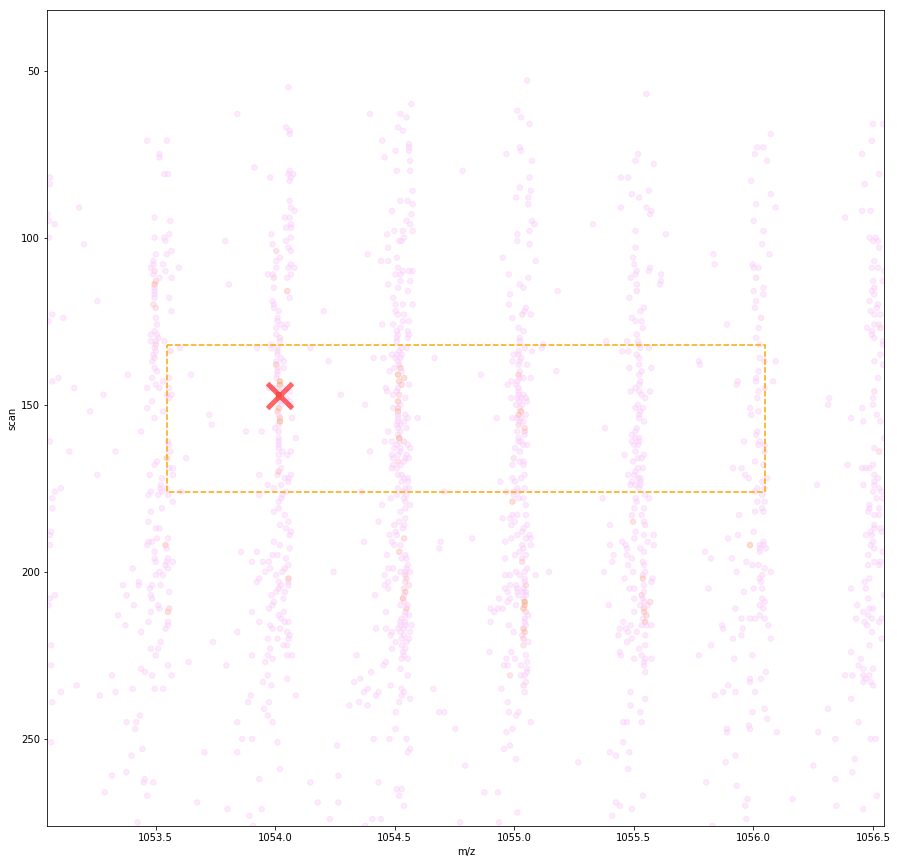

In [18]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_cuboid_points_ap_frame_df.mz, wide_cuboid_points_ap_frame_df.scan, c=wide_cuboid_points_ap_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the cuboid extent
top_left = (mz_lower,scan_lower)
width = mz_upper - mz_lower
height = scan_upper - scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='orange',facecolor='none')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

plt.xlim([wide_mz_lower, wide_mz_upper])
plt.ylim([wide_scan_lower, wide_scan_upper])

plt.gca().invert_yaxis()
plt.show()

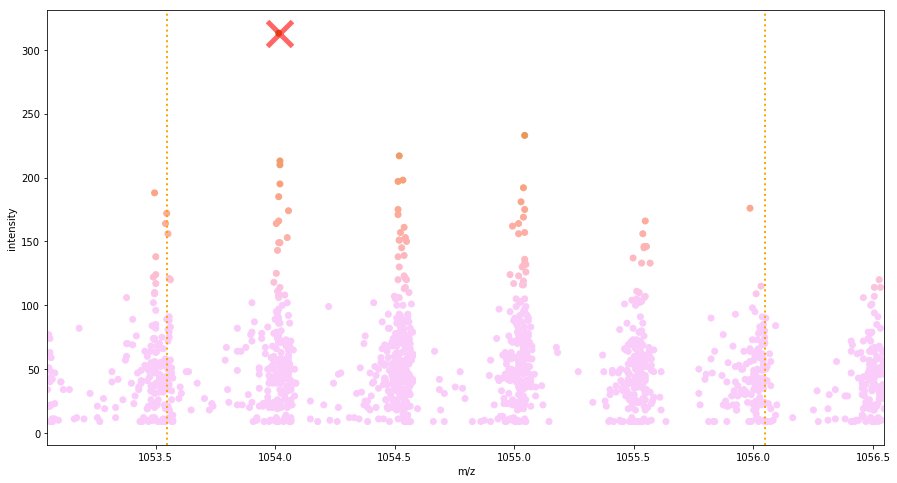

In [19]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_cuboid_points_ap_frame_df.mz, wide_cuboid_points_ap_frame_df.intensity, c=wide_cuboid_points_ap_frame_df.intensity, cmap=colour_map, norm=norm)
plt.axvline(x=mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=mz_upper, linestyle=':', color='orange', linewidth=2)
plt.plot(ap_mz, ap_intensity, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point', alpha=0.6)

plt.xlim([wide_mz_lower, wide_mz_upper])

plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

In [20]:
wide_scan_df = wide_cuboid_points_df.groupby(['scan'], as_index=False).intensity.sum()
wide_scan_df.sort_values(by=['scan'], ascending=True, inplace=True)

In [21]:
len(wide_scan_df)

240

In [22]:
# determine the maximum filter length for the number of points
def find_filter_length(number_of_points):
    filter_lengths = [51,41,31,21,11,7,5]  # must be a positive odd number, greater than the polynomial order, and less than the number of points to be filtered
    return filter_lengths[next(x[0] for x in enumerate(filter_lengths) if x[1] < number_of_points)]

In [46]:
# filter the points
wide_scan_df['filtered_intensity'] = wide_scan_df.intensity  # set the default
try:
    wide_scan_df['filtered_intensity'] = signal.savgol_filter(wide_scan_df.intensity, window_length=find_filter_length(number_of_points=len(wide_scan_df)), polyorder=3)
    filtered = True
except:
    filtered = False

In [47]:
peak_idxs = peakutils.indexes(wide_scan_df.filtered_intensity.values, thres=0.5, min_dist=PEAKS_MIN_DIST_SCAN, thres_abs=False)
peak_x_l = wide_scan_df.iloc[peak_idxs].scan.to_list()
peaks_df = wide_scan_df[wide_scan_df.scan.isin(peak_x_l)]

In [48]:
peaks_df

,scan,intensity,filtered_intensity
175,212,21995,20285.665655


In [49]:
df = peaks_df.copy()
if len(df) > 1:
    # find the closest peak to the anchor point
    df['delta'] = abs(df.scan - ap_scan)
    df.sort_values(by=['delta'], ascending=True, inplace=True)
peaks_s = df.iloc[0]    

In [50]:
peaks_s

scan                    212.000000
intensity             21995.000000
filtered_intensity    20285.665655
Name: 175, dtype: float64

In [51]:
valley_idxs = peakutils.indexes(-wide_scan_df.filtered_intensity.values, thres=0.2, min_dist=5, thres_abs=False)
valley_x_l = wide_scan_df.iloc[valley_idxs].scan.to_list()
valleys_df = wide_scan_df[wide_scan_df.scan.isin(valley_x_l)]

upper_x = valleys_df[valleys_df.scan > ap_scan].scan.min()
if math.isnan(upper_x):
    upper_x = wide_scan_df.scan.max()
lower_x = valleys_df[valleys_df.scan < ap_scan].scan.max()
if math.isnan(lower_x):
    lower_x = wide_scan_df.scan.min()

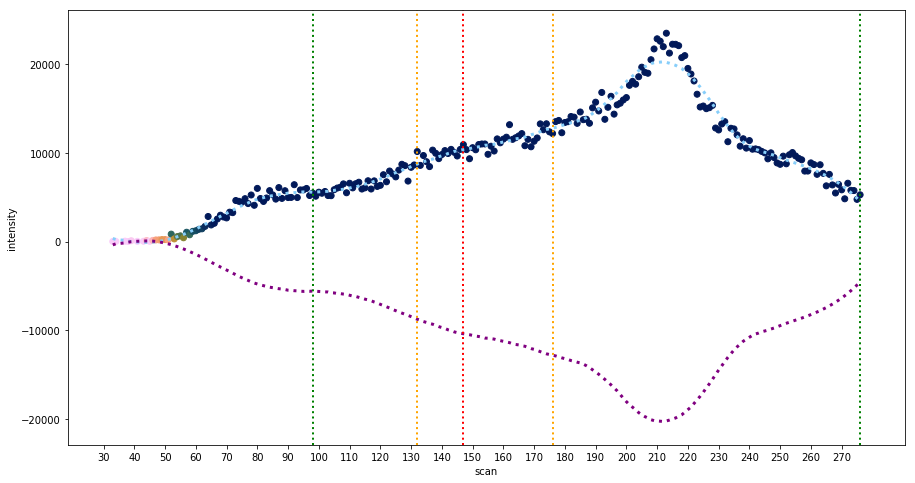

In [52]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_scan_df.scan, wide_scan_df.intensity, c=wide_scan_df.intensity, cmap=colour_map, norm=norm)
plt.plot(wide_scan_df.scan, wide_scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')
plt.plot(wide_scan_df.scan, -wide_scan_df.filtered_intensity, marker='', color='purple', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.axvline(x=scan_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=scan_upper, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=ap_scan, linestyle=':', color='red', linewidth=2)

plt.axvline(x=lower_x, linestyle=':', color='green', linewidth=2)
plt.axvline(x=upper_x, linestyle=':', color='green', linewidth=2)

range_l = round(wide_scan_df.scan.min() / 10) * 10
range_u = round(wide_scan_df.scan.max() / 10) * 10
plt.xticks(np.arange(range_l,range_u,10.0))

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [53]:
wide_rt_df = wide_cuboid_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
wide_rt_df.sort_values(by=['frame_id','retention_time_secs'], ascending=True, inplace=True)

In [54]:
# filter the points
wide_rt_df['filtered_intensity'] = wide_rt_df.intensity  # set the default
try:
    wide_rt_df['filtered_intensity'] = signal.savgol_filter(wide_rt_df.intensity, window_length=find_filter_length(number_of_points=len(wide_rt_df)), polyorder=3)
    filtered = True
except:
    filtered = False

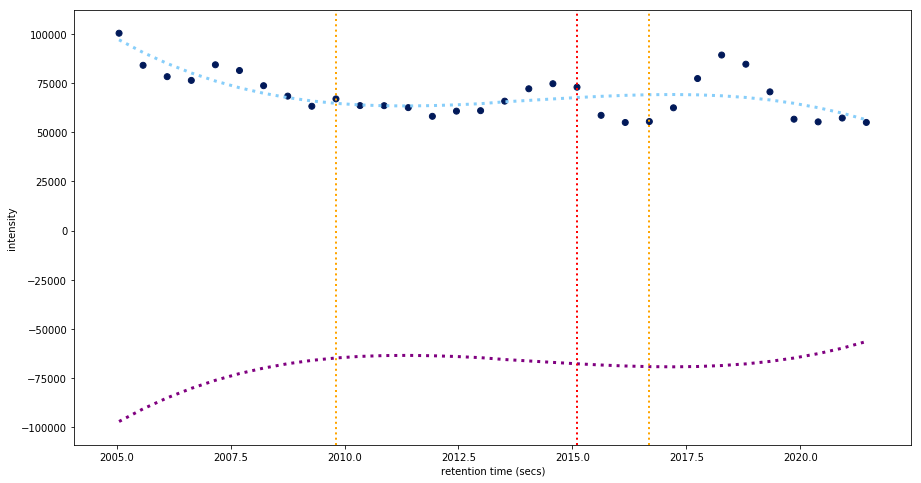

In [55]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_rt_df.retention_time_secs, wide_rt_df.intensity, c=wide_rt_df.intensity, cmap=colour_map, norm=norm)
plt.plot(wide_rt_df.retention_time_secs, wide_rt_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')
plt.plot(wide_rt_df.retention_time_secs, -wide_rt_df.filtered_intensity, marker='', color='purple', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.axvline(x=rt_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=rt_upper, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=ap_rt, linestyle=':', color='red', linewidth=2)

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()